**Importing packages**

In [128]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import re
import string
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from collections import Counter

In [1]:
#connecting to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [130]:
data = pd.read_csv('/content/drive/My Drive/mads/nlp/merged_df.csv')
data.head()

<ipython-input-130-0b5481957d22>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/drive/My Drive/mads/nlp/merged_df.csv')


,Title,Abstract,Disciplines,Keywords,Source
0,The Veldkamp Space of Two-Qubits,Given a remarkable representation of the gen...,Physics,NaN,arXiv
1,Axiom A polynomial skew products of C^2 and th...,A polynomial skew product of C^2 is a map of...,Mathematics,NaN,arXiv
2,"Quasi Ordinary Singularities, Essential Diviso...",We define Poincar\'e series associated to a ...,Mathematics,NaN,arXiv
3,Third Order Newton's Method for Zernike Polyno...,The Zernike radial polynomials are a system ...,Mathematics,NaN,arXiv
4,Quantum Properties and Gravitational Field of ...,We find that a field with oscillations of ma...,Physics,NaN,arXiv


**Basic Data cleaning**

In [131]:
data.isna().mean()*100

,0
Title,0.000000
Abstract,0.000000
Disciplines,0.000000
Keywords,96.991026
Source,0.000000


In [132]:
data = data.drop(columns=['Keywords'])

**Data analysis**

In [133]:
data.shape

(311568, 4)

In [134]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311568 entries, 0 to 311567
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Title        311568 non-null  object
 1   Abstract     311568 non-null  object
 2   Disciplines  311568 non-null  object
 3   Source       311568 non-null  object
dtypes: object(4)
memory usage: 9.5+ MB


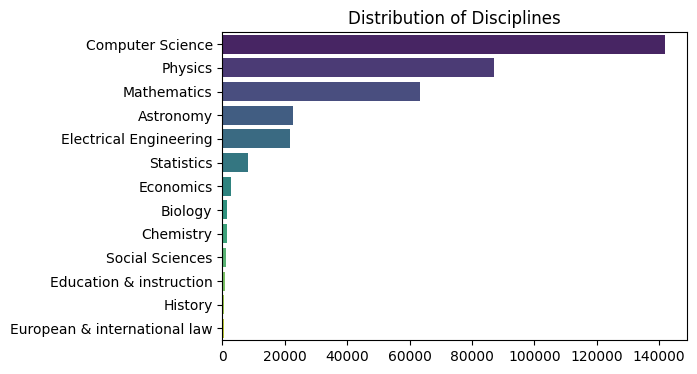

In [143]:
all_tags = [tag for sublist in data['Disciplines'].apply(lambda x: x.split('/')) for tag in sublist]
tag_counts = Counter(all_tags)
tag_df = pd.DataFrame.from_dict(tag_counts, orient='index', columns=['Count'])
tag_df = tag_df.sort_values(by='Count', ascending=False)

plt.figure(figsize=(6, 4))
sns.barplot(y=tag_df.index, hue=tag_df.index, x=tag_df['Count'], palette='viridis')

plt.title('Distribution of Disciplines')
plt.xlabel('')
plt.ylabel('')
plt.show()

**Data Preprocessing**

In [146]:
data['Disciplines'] = data['Disciplines'].apply(lambda x: x.split('/'))
data.head()

,Title,Abstract,Disciplines,Source
0,The Veldkamp Space of Two-Qubits,Given a remarkable representation of the gen...,[Physics],arXiv
1,Axiom A polynomial skew products of C^2 and th...,A polynomial skew product of C^2 is a map of...,[Mathematics],arXiv
2,"Quasi Ordinary Singularities, Essential Diviso...",We define Poincar\'e series associated to a ...,[Mathematics],arXiv
3,Third Order Newton's Method for Zernike Polyno...,The Zernike radial polynomials are a system ...,[Mathematics],arXiv
4,Quantum Properties and Gravitational Field of ...,We find that a field with oscillations of ma...,[Physics],arXiv


In [117]:
mlb = MultiLabelBinarizer()
tag_matrix = mlb.fit_transform(data['Disciplines'])
tag_df = pd.DataFrame(tag_matrix, columns=mlb.classes_)
data = pd.concat([data, tag_df], axis=1)
print(data)

                                                    Title  \
0                        The Veldkamp Space of Two-Qubits   
1       Axiom A polynomial skew products of C^2 and th...   
2       Quasi Ordinary Singularities, Essential Diviso...   
3       Third Order Newton's Method for Zernike Polyno...   
4       Quantum Properties and Gravitational Field of ...   
...                                                   ...   
311563  Neural Symbolic Architecture for Normative Agents   
311564  Comparison of Low-Latency Anonymous Communicat...   
311565  Learning and Reasoning about Norms using Neura...   
311566  Visualizing Normative Systems: an Abstract App...   
311567  SNR Estimation for Multi-dimensional Cognitive...   

                                                 Abstract  \
0         Given a remarkable representation of the gen...   
1         A polynomial skew product of C^2 is a map of...   
2         We define Poincar\'e series associated to a ...   
3         The Zernike r

In [82]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [121]:
def preprocess_text(text):
    text = re.sub(r"^\[en\]\s*", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    tokens = text.split()
    tokens = [word.lower() for word in tokens if word.lower() not in stop_words]

    return " ".join(tokens)

data['tokens'] = data['Abstract'].apply(preprocess_text)

In [122]:
data['tokens'].head()

,tokens
0,given remarkable representation generalized pa...
1,polynomial skew product c2 map form fzw pz qzw...
2,define poincare series associated toric analyt...
3,zernike radial polynomials system orthogonal p...
4,find field oscillations matter proper time pro...


In [123]:
X = data['tokens']
y = tag_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))

Training set size: 249254
Testing set size: 62314


In [124]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),  # TF-IDF vectorization
    ('clf', MultiOutputClassifier(LogisticRegression(max_iter=1000)))  # Multi-label classifier with Logistic Regression
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred, target_names=mlb.classes_))

Classification Report:
                               precision    recall  f1-score   support

                   Astronomy       0.98      0.93      0.96      4557
                     Biology       0.94      0.48      0.64       317
                   Chemistry       0.72      0.19      0.30       302
            Computer Science       0.94      0.94      0.94     28477
                   Economics       0.73      0.22      0.34       544
     Education & instruction       0.79      0.36      0.50       155
      Electrical Engineering       0.76      0.52      0.62      4406
European & international law       0.88      0.51      0.65       103
                     History       0.86      0.29      0.43       124
                 Mathematics       0.92      0.88      0.90     12679
                     Physics       0.94      0.91      0.92     17368
             Social Sciences       0.91      0.36      0.51       204
                  Statistics       0.83      0.54      0.65      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [125]:
y_test_tags = mlb.inverse_transform(y_test)
y_pred_tags = mlb.inverse_transform(y_pred)


results_df = pd.DataFrame({
    'Abstract': X_test,
    'True Tags': y_test_tags,
    'Predicted Tags': y_pred_tags
})

results_df.head()

,Abstract,True Tags,Predicted Tags
241183,discuss nonparametric mixing distribution esti...,"(Mathematics, Statistics)","(Mathematics, Statistics)"
270700,investigate maximum cut maxcut problem differe...,"(Physics,)","(Physics,)"
168657,mobile traffic data urban regions shows differ...,"(Computer Science,)","(Computer Science,)"
139416,dipolar fixed point introduced aharony fisher ...,"(Physics,)","(Physics,)"
86542,optical mirrors determine cavity properties me...,"(Physics,)","(Physics,)"


In [127]:
results_df[results_df['True Tags'] != results_df['Predicted Tags']]

,Abstract,True Tags,Predicted Tags
194841,phasor measurement units pmus provide highreso...,"(Electrical Engineering,)","(Computer Science, Electrical Engineering)"
70414,current fossil fuel climate crisis led increas...,"(Mathematics,)","(Computer Science, Electrical Engineering)"
35923,present algorithm compressing radiosity view f...,"(Mathematics,)",()
265665,present results neutral hydrogen hi followup s...,"(Astronomy, Physics)","(Astronomy,)"
100753,counterfactual inference aims answer retrospec...,"(Computer Science, Statistics)","(Computer Science,)"
...,...,...,...
289872,diffusion problems anisotropic features arise ...,"(Computer Science,)",()
113328,paper propose estimate forward dynamics equati...,"(Computer Science, Electrical Engineering)","(Computer Science,)"
245101,mixed frequency data shown improve performance...,"(Economics,)",()
48902,though s0 galaxies usually thought red dead of...,"(Astronomy, Physics)","(Astronomy,)"
